#### Notebook purpose:

- compare carbon budget between model T001 and M001 model runs
- consider air-sea flux

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle

#import mapfxn as mf
#reload(mf)

plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

# meshmask

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


(31,)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


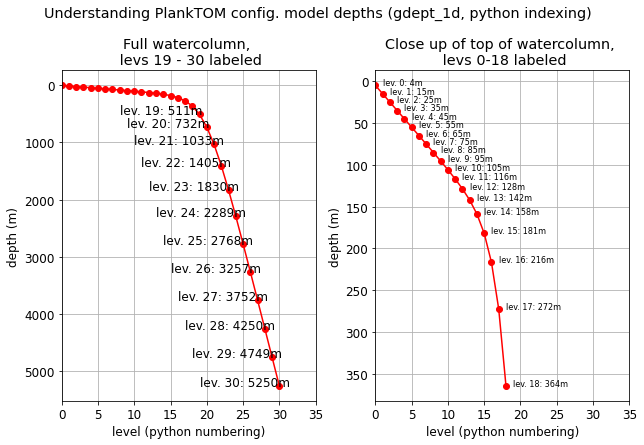

In [3]:
tnc = nc.Dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')


tdepths = (tnc['gdept_1d'][0,:])
print(np.shape(tdepths))
tind = np.arange(0,len(tdepths),1)

fact = 0.45
fig, axs = plt.subplots(1,2, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(19,len(tdepths)):
    axs[0].text(i-11,tdepths[i],f'lev. {i}: {int(tdepths[i])}m')
axs[0].plot(tind,tdepths,'ro-')
axs[0].invert_yaxis()
axs[0].grid()
axs[0].set_xlim([0,35])
axs[0].set_title('Full watercolumn, \n levs 19 - 30 labeled')

axs[1].plot(tind[0:19],tdepths[0:19],'ro-')
for i in range(0,19):
    axs[1].text(i+1,tdepths[i],f'lev. {i}: {int(tdepths[i])}m', fontsize = 8)
axs[1].invert_yaxis()
axs[1].grid()
axs[1].set_xlim([0,35])
axs[1].set_title('Close up of top of watercolumn, \n levs 0-18 labeled')

for i in range(0,2):
    axs[i].set_xlabel('level (python numbering)')
    axs[i].set_ylabel('depth (m)')

plt.suptitle('Understanding PlankTOM config. model depths (gdept_1d, python indexing)')
plt.tight_layout()

In [38]:
tnc = nc.Dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')

# print(tnc)
#lon?
e1t = tnc['e1t'][0,:,:]
e2t = tnc['e2t'][0,:,:]
e3t = tnc['e3t_0'][0,:,:,:]
tmask = tnc['tmask'][0,:,:,:]
print(tnc['nav_lat'][0:37,0])
surf_area_broad = np.zeros_like(e3t)
for i in range(0,31):
    surf_area_broad[i,:,:] = e1t*e2t
    
vol_m3 = surf_area_broad*e3t
vol_m3_m = surf_area_broad*e3t*tmask

landmask = nc.Dataset('../UTILS/sector_landmask.nc')
print(landmask)
lm = (landmask['sectormask'][:,:])
# tdepths = (tnc['gdept_1d'][0,:])
# print(np.shape(tdepths))
# tind = np.arange(0,len(tdepths),1)
lm_broad = np.zeros([31,149,182])
for i in range(0,31):
    lm_broad[i,:,:] = lm
    
lm_broad = lm_broad[:,0:37,:]

[-78.19058  -77.7742   -77.34337  -76.89761  -76.43644  -75.95934
 -75.46582  -74.95534  -74.42735  -73.88131  -73.31665  -72.73279
 -72.129135 -71.5051   -70.86005  -70.193375 -69.50445  -68.792625
 -68.05725  -67.29768  -66.51326  -65.703316 -64.867195 -64.00423
 -63.113754 -62.195126 -61.247692 -60.27082  -59.263885 -58.226284
 -57.15743  -56.05677  -54.923775 -53.75795  -52.558838 -51.326035
 -50.059177]
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    description: made in EVAL_forcing/so_landmask.ipynb, 1 land, 2 atl, 3 ind, 4 pac
    dimensions(sizes): x(182), y(149)
    variables(dimensions): float32 sectormask(y,x)
    groups: 


In [40]:

def totC_in_pG(yrstart, yrend, trun):

    # tnc = nc.Dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    # tdepths = (tnc['gdept_1d'][0,:])
    # print(f'extracting var. {varnam} ({ncnam}) at lev. {depth} ({int(tdepths[depth])}m), yrs {yrstart}-{yrend}')

    ncnam = 'grid'; varnam = 'vosaline'
    yrs = np.arange(yrstart,yrend+1,1)
    tq_sum_ts = np.zeros([4,31,len(yrs)])
     
    rdir = '/gpfs/data/greenocean/software/runs/'
    print(len(yrs))
    for i in range(0,len(yrs)):
        if i%20 == 0:
            print(i)
        yr = yrs[i]
        w = glob.glob(f'{rdir}{trun}/ORCA*{yr}01*{ncnam}_T.nc')
        tnam = w[0]
        tfil = nc.Dataset(tnam)
        tq = tfil[varnam][:,:,0:37,:]
        #print(np.shape(tq))
        #annual average
        tq_ave = np.nanmean(tq,axis=0)
        tq_ave[tq_ave == 0] = np.nan
        #1 land, 2 atl, 3 ind, 4 pac
        tq_ave_in = np.copy(tq_ave)
        tq_ave_in[lm_broad != 3] = np.nan
        tq_ave_pac = np.copy(tq_ave)
        tq_ave_pac[lm_broad != 4] = np.nan
        tq_ave_atl = np.copy(tq_ave)
        tq_ave_atl[lm_broad != 2] = np.nan

        tq_ave_fd = np.nanmean(np.nanmean(tq_ave,axis =1),axis = 1)
        tq_ave_atl_fd = np.nanmean(np.nanmean(tq_ave_atl,axis =1),axis = 1)
        tq_ave_pac_fd = np.nanmean(np.nanmean(tq_ave_pac,axis =1),axis = 1)
        tq_ave_in_fd = np.nanmean(np.nanmean(tq_ave_in,axis =1),axis = 1)

        
        tq_sum_ts[0,:,i] = tq_ave_fd
        tq_sum_ts[1,:,i] = tq_ave_atl_fd
        tq_sum_ts[2,:,i] = tq_ave_in_fd
        tq_sum_ts[3,:,i] = tq_ave_pac_fd

    return tq_sum_ts
S_T001 = totC_in_pG(1948, 2020, 'TOM12_TJ_T001')
S_M001 = totC_in_pG(1948, 2020, 'TOM12_TJ_M001')
#C_Pg_M001 = totC_in_pG(1948, 2020, 'TOM12_TJ_M001')

73
0
20
40
60
73
0
20
40
60


Text(0.5, 0.98, 'average salinity, SO south of 50 south')

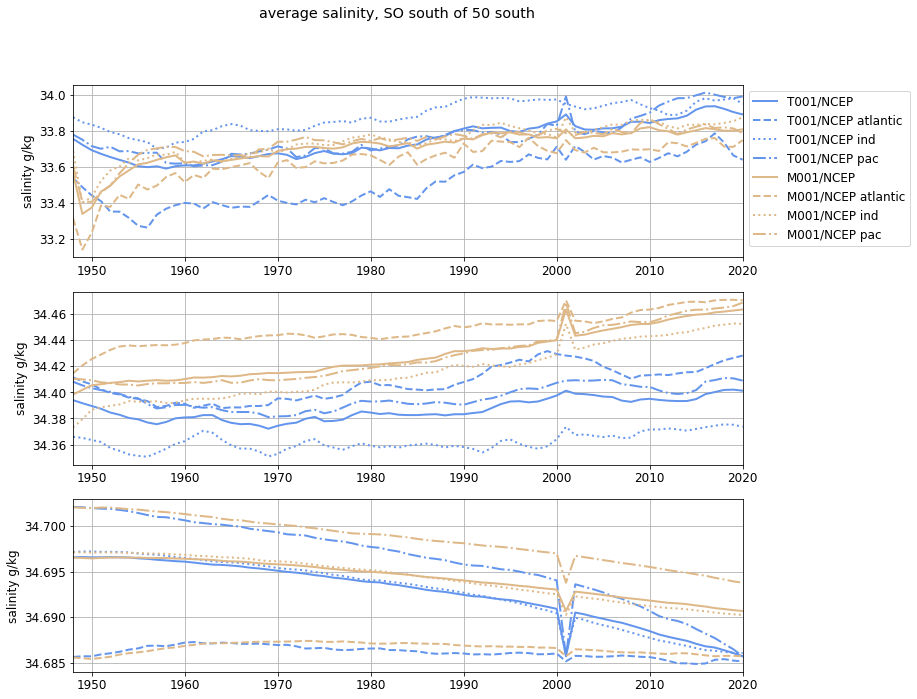

In [41]:
m0colst = 'peru'; M0col = 'burlywood'
t0colst = 'blue'; t0col = 'cornflowerblue'

fact = 0.6
fig, axs = plt.subplots(3,1, figsize=(20*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
yrs = np.arange(1948,2021,1)
td = 0
axs[0].plot(yrs,S_T001[0,td,:],color = t0col, linestyle = '-', lw =2, label = 'T001/NCEP')
axs[0].plot(yrs,S_T001[1,td,:],color = t0col, linestyle = '--', lw =2, label = 'T001/NCEP atlantic')
axs[0].plot(yrs,S_T001[2,td,:],color = t0col, linestyle = ':', lw =2, label = 'T001/NCEP ind')
axs[0].plot(yrs,S_T001[3,td,:],color = t0col, linestyle = '-.', lw =2, label = 'T001/NCEP pac')

axs[0].plot(yrs,S_M001[0,td,:],color = M0col, linestyle = '-', lw =2, label = 'M001/NCEP')
axs[0].plot(yrs,S_M001[1,td,:],color = M0col, linestyle = '--', lw =2, label = 'M001/NCEP atlantic')
axs[0].plot(yrs,S_M001[2,td,:],color = M0col, linestyle = ':', lw =2, label = 'M001/NCEP ind')
axs[0].plot(yrs,S_M001[3,td,:],color = M0col, linestyle = '-.', lw =2, label = 'M001/NCEP pac')
td = 19
axs[1].plot(yrs,S_T001[0,td,:],color = t0col, linestyle = '-', lw =2, label = 'T001/NCEP')
axs[1].plot(yrs,S_T001[1,td,:],color = t0col, linestyle = '--', lw =2, label = 'T001/NCEP atlantic')
axs[1].plot(yrs,S_T001[2,td,:],color = t0col, linestyle = ':', lw =2, label = 'T001/NCEP ind')
axs[1].plot(yrs,S_T001[3,td,:],color = t0col, linestyle = '-.', lw =2, label = 'T001/NCEP pac')

axs[1].plot(yrs,S_M001[0,td,:],color = M0col, linestyle = '-', lw =2, label = 'M001/NCEP')
axs[1].plot(yrs,S_M001[1,td,:],color = M0col, linestyle = '--', lw =2, label = 'M001/NCEP atlantic')
axs[1].plot(yrs,S_M001[2,td,:],color = M0col, linestyle = ':', lw =2, label = 'M001/NCEP ind')
axs[1].plot(yrs,S_M001[3,td,:],color = M0col, linestyle = '-.', lw =2, label = 'M001/NCEP pac')
td = 28
axs[2].plot(yrs,S_T001[0,td,:],color = t0col, linestyle = '-', lw =2, label = 'T001/NCEP')
axs[2].plot(yrs,S_T001[1,td,:],color = t0col, linestyle = '--', lw =2, label = 'T001/NCEP atlantic')
axs[2].plot(yrs,S_T001[2,td,:],color = t0col, linestyle = ':', lw =2, label = 'T001/NCEP ind')
axs[2].plot(yrs,S_T001[3,td,:],color = t0col, linestyle = '-.', lw =2, label = 'T001/NCEP pac')

axs[2].plot(yrs,S_M001[0,td,:],color = M0col, linestyle = '-', lw =2, label = 'M001/NCEP')
axs[2].plot(yrs,S_M001[1,td,:],color = M0col, linestyle = '--', lw =2, label = 'M001/NCEP atlantic')
axs[2].plot(yrs,S_M001[2,td,:],color = M0col, linestyle = ':', lw =2, label = 'M001/NCEP ind')
axs[2].plot(yrs,S_M001[3,td,:],color = M0col, linestyle = '-.', lw =2, label = 'M001/NCEP pac')

# axs[0].plot(yrs,C_Pg_M001[3,:],color = m0col, linestyle = '-', label = 'total C, M001/MO')
# axs[1].plot(yrs,C_Pg_T001[0,:],color = t0col, linestyle = '-', label = 'surf 500m C, T001/NCEP')
# axs[1].plot(yrs,C_Pg_M001[0,:],color = m0col, linestyle = '-', label = 'surf 500m C, M001/MO')
# axs[2].plot(yrs,C_Pg_T001[1,:],color = t0col, linestyle = '-', label = '500m-2200m C, T001/NCEP')
# axs[2].plot(yrs,C_Pg_M001[1,:],color = m0col, linestyle = '-', label = '500m-2200m C, M001/MO')
# axs[3].plot(yrs,C_Pg_T001[2,:],color = t0col, linestyle = '-', label = 'below 2200m C, T001/NCEP')
# axs[3].plot(yrs,C_Pg_M001[2,:],color = m0col, linestyle = '-', label = 'below 2200m C, M001/MO')

for i in range(0,3):
    axs[i].grid()
    axs[0].legend(bbox_to_anchor = [1,1])
    axs[i].set_ylabel('salinity g/kg')
    axs[i].set_xlim(1948,2020)
    
plt.suptitle('average salinity, SO south of 50 south')

In [ ]:

def totC_in_pG(yrstart, yrend, trun):

    # tnc = nc.Dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    # tdepths = (tnc['gdept_1d'][0,:])
    # print(f'extracting var. {varnam} ({ncnam}) at lev. {depth} ({int(tdepths[depth])}m), yrs {yrstart}-{yrend}')

    ncnam = 'ptrc'; varnam = 'DIC'
    yrs = np.arange(yrstart,yrend+1,1)
    tq_sum_ts = np.zeros([4,len(yrs)])
     
    rdir = '/gpfs/data/greenocean/software/runs/'
    print(len(yrs))
    for i in range(0,len(yrs)):
        if i%20 == 0:
            print(i)
        yr = yrs[i]
        w = glob.glob(f'{rdir}{trun}/ORCA*{yr}01*{ncnam}_T.nc')
        tnam = w[0]
        tfil = nc.Dataset(tnam)
        tq = tfil[varnam]
        #annual average
        tq_ave = np.nanmean(tq,axis=0)
        #for DIC: get mols per cell. units are mol/L, there are 1000L per m3, we have m3/cell f
        tq_mol_cell = tq_ave * vol_m3_m
        #mols to pG
        topG = 1e-15 * 12
        #mask out southern ocean:
        tq_sum_ts[0,i] = np.nansum(tq_mol_cell[0:19,:,:]) *topG
        tq_sum_ts[1,i] = np.nansum(tq_mol_cell[19:24,:,:])*topG
        tq_sum_ts[2,i] = np.nansum(tq_mol_cell[24:31,:,:])*topG
        tq_sum_ts[3,i] = np.nansum(tq_mol_cell[0:31,:,:])*topG
    return tq_sum_ts
C_Pg_T001_FO = totC_in_pG(1948, 2020, 'TOM12_TJ_T001')
C_Pg_M001_FO = totC_in_pG(1948, 2020, 'TOM12_TJ_M001')

In [ ]:
m0colst = 'peru'; m0col = 'burlywood'
t0colst = 'blue'; t0col = 'cornflowerblue'

fact = 0.6
fig, axs = plt.subplots(2,2, figsize=(20*fact, 13*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
yrs = np.arange(1948,2021,1)
axs[0].plot(yrs,C_Pg_T001_FO[3,:],color = t0col, linestyle = '-', label = 'total C, T001/NCEP')
axs[0].plot(yrs,C_Pg_M001_FO[3,:],color = m0col, linestyle = '-', label = 'total C, M001/MO')
axs[1].plot(yrs,C_Pg_T001_FO[0,:],color = t0col, linestyle = '-', label = 'surf 500m C, T001/NCEP')
axs[1].plot(yrs,C_Pg_M001_FO[0,:],color = m0col, linestyle = '-', label = 'surf 500m C, M001/MO')
axs[2].plot(yrs,C_Pg_T001_FO[1,:],color = t0col, linestyle = '-', label = '500m-2200m C, T001/NCEP')
axs[2].plot(yrs,C_Pg_M001_FO[1,:],color = m0col, linestyle = '-', label = '500m-2200m C, M001/MO')
axs[3].plot(yrs,C_Pg_T001_FO[2,:],color = t0col, linestyle = '-', label = 'below 2200m C, T001/NCEP')
axs[3].plot(yrs,C_Pg_M001_FO[2,:],color = m0col, linestyle = '-', label = 'below 2200m C, M001/MO')

for i in range(0,4):
    axs[i].grid()
    axs[i].legend()
    axs[i].set_ylabel('petagrams C')
    axs[i].set_xlim(1948,2020)
    
plt.suptitle('total petagrams C - full ocean domain')

In [ ]:
tnc = nc.Dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')

# print(tnc)
#lon?
e1t = tnc['e1t'][0,:,:]
e2t = tnc['e2t'][0,:,:]
e3t = tnc['e3t_0'][0,:,:,:]
tmask = tnc['tmask'][0,:,:,:]

surf_area_broad = np.zeros_like(e3t)
for i in range(0,31):
    surf_area_broad[i,:,:] = e1t*e2t
    
vol_m3 = surf_area_broad*e3t
vol_m3_m = surf_area_broad*e3t*tmask


days_in_month = np.array([31,28,31,30,31,30,31,31,30,31,30,31])


surfar_times_days_in_month = surf_area_broad[0:12,:,:]

for i in range(0,12):
    surfar_times_days_in_month[i,:,:] = surf_area_broad[i,:,:] * days_in_month[i]
    
    
print(surfar_times_days_in_month[0,20,20]/surfar_times_days_in_month[1,20,20])


In [ ]:
yrstart = 1948; yrend = 2020
ncnam = 'diad'; varnam = 'Cflx'
yrs = np.arange(yrstart,yrend+1,1)
monthflx_ts_T001 = np.zeros([12,len(yrs)])
rdir = '/gpfs/data/greenocean/software/runs/'
trun = 'TOM12_TJ_T001'
print(len(yrs))
for i in range(0,len(yrs)):
    if i%20 == 0:
        print(i)
    yr = yrs[i]
    w = glob.glob(f'{rdir}{trun}/ORCA*{yr}01*{ncnam}_T.nc')
    tnam = w[0]
    #print(tnam)
    tfil = nc.Dataset(tnam)
    tq = tfil[varnam][:,:,:]
    sid = 60*60*24
    # now it's in petagrams total done by each cell 
    totflx = surfar_times_days_in_month * tq * sid * 12 * 1e-15
    monthflux= np.nansum(np.nansum(totflx,axis = 1),axis=1)
    monthflx_ts_T001[:,i] = monthflux

monthflx_ts_M001 = np.zeros([12,len(yrs)])
rdir = '/gpfs/data/greenocean/software/runs/'
trun = 'TOM12_TJ_M001'
print(len(yrs))
for i in range(0,len(yrs)):
    if i%20 == 0:
        print(i)
    yr = yrs[i]
    w = glob.glob(f'{rdir}{trun}/ORCA*{yr}01*{ncnam}_T.nc')
    tnam = w[0]
    #print(tnam)
    tfil = nc.Dataset(tnam)
    tq = tfil[varnam][:,:,:]
    sid = 60*60*24
    # now it's in petagrams total done by each cell 
    totflx = surfar_times_days_in_month * tq * sid * 12 * 1e-15
    monthflux= np.nansum(np.nansum(totflx,axis = 1),axis=1)
    monthflx_ts_M001[:,i] = monthflux
        
        #cflx is in mol/m2/s. s/day sid = 60*60*24. multiply resulting array by 
        #for DIC: get mols per cell. units are mol/L, there are 1000L per m3, we have m3/cell f
        # tq_mol_cell = tq_ave * vol_m3_m
        # #mols to pG
        # topG = 1e-15 * 12
        # #mask out southern ocean:
        # tq_sum_ts[0,i] = np.nansum(tq_mol_cell[0:19,0:37,:]) *topG
        # tq_sum_ts[1,i] = np.nansum(tq_mol_cell[19:24,0:37,:])*topG
        # tq_sum_ts[2,i] = np.nansum(tq_mol_cell[24:31,0:37,:])*topG
        # tq_sum_ts[3,i] = np.nansum(tq_mol_cell[0:31,0:37,:])*topG
    # return tq_sum_ts


#C_Pg_M001 = totC_in_pG(1948, 2020, 'TOM12_TJ_M001')

In [ ]:
yrs_int = np.arange(1948,2021,1)
fact = 0.5
fig, axs = plt.subplots(6,2, figsize=(20*fact, 25*fact), \
                        facecolor='w', edgecolor='k')
axs = axs.ravel() 

T0colst = 'blue'; T0col = 'cornflowerblue'
M0colst = 'peru'; M0col = 'burlywood'
for m in range(0,12):

    axs[m].plot(yrs_int,monthflx_ts_M001[m,:],\
                color = M0colst, linestyle = '-',linewidth = 2, label = 'M001')
    axs[m].plot(yrs_int,monthflx_ts_T001[m,:],\
                color = T0colst, linestyle = '-',linewidth = 2, label = 'T001')
  
tt = ['summer','summer','fall','fall','fall','winter','winter','winter',\
      'spring','spring','spring','summer']
for i in range(0,12):

    axs[i].set_xlim([1948,2020])
    axs[i].set_ylim([-0.1,0.5])
    axs[i].set_title(f'month {i+1} ({tt[i]})')
    axs[i].grid()
    axs[i].set_ylabel('pG')
    axs[i].axhline(y=0, color = 'k')
    axs[0].legend(loc = 'best', fontsize = 8.5, ncol = 1)
tit1 = '(full domain) Model carbon sink, pG, T001-NCEP, M001-MetOffice'
tit2 = 'subdivided by month'
#plt.suptitle(, \n SO (<-50 lat.), mean and range for a given month in red, \n (unweighted in blue, basically similar), full-year range in black')
plt.suptitle(f'{tit1}\n{tit2}')
plt.tight_layout()
             #axs.plot(yrs_dec,,'ro:')

In [ ]:
yrs_int = np.arange(1948,2021,1)
fact = 0.5
fig, axs = plt.subplots(1,1, figsize=(20*fact, 9*fact), \
                        facecolor='w', edgecolor='k')


T0colst = 'blue'; T0col = 'cornflowerblue'
M0colst = 'peru'; M0col = 'burlywood'

axs.plot(yrs_int,np.nansum(monthflx_ts_M001[:,:], axis = 0),\
            color = M0colst, linestyle = '-',linewidth = 2, label = 'M001')
axs.plot(yrs_int,np.nansum(monthflx_ts_T001[:,:], axis = 0),\
            color = T0colst, linestyle = '-',linewidth = 2, label = 'T001')

tt = ['summer','summer','fall','fall','fall','winter','winter','winter',\
      'spring','spring','spring','summer']


axs.set_xlim([1948,2020])
#axs.set_ylim([-0.1,0.5])
#axs.set_title(f'month {i+1} ({tt})')
axs.grid()
axs.set_ylabel('pG')
axs.axhline(y=0, color = 'k')
axs.legend(loc = 'best', fontsize = 8.5, ncol = 1)
tit1 = '(full domain) yearly Model carbon sink, pG, T001-NCEP, M001-MetOffice'
tit2 = ''
#plt.suptitle(, \n SO (<-50 lat.), mean and range for a given month in red, \n (unweighted in blue, basically similar), full-year range in black')
plt.suptitle(f'{tit1}\n{tit2}')
plt.tight_layout()
             #axs.plot(yrs_dec,,'ro:')

### sink for soutehrn ocean south of 30 south

In [ ]:
yrstart = 1948; yrend = 2020
ncnam = 'diad'; varnam = 'Cflx'
yrs = np.arange(yrstart,yrend+1,1)
monthflx_ts_T001_SO = np.zeros([12,len(yrs)])
rdir = '/gpfs/data/greenocean/software/runs/'
trun = 'TOM12_TJ_T001'
print(len(yrs))
for i in range(0,len(yrs)):
    if i%20 == 0:
        print(i)
    yr = yrs[i]
    w = glob.glob(f'{rdir}{trun}/ORCA*{yr}01*{ncnam}_T.nc')
    tnam = w[0]
    #print(tnam)
    tfil = nc.Dataset(tnam)
    tq = tfil[varnam][:,0:50,:]
    #print(np.shape(tq))
    sid = 60*60*24
    # now it's in petagrams total done by each cell 
    totflx = surfar_times_days_in_month[:,0:50,:] * tq * sid * 12 * 1e-15
    monthflux= np.nansum(np.nansum(totflx,axis = 1),axis=1)
    monthflx_ts_T001_SO[:,i] = monthflux

monthflx_ts_M001_SO = np.zeros([12,len(yrs)])
rdir = '/gpfs/data/greenocean/software/runs/'
trun = 'TOM12_TJ_M001'
print(len(yrs))
for i in range(0,len(yrs)):
    if i%20 == 0:
        print(i)
    yr = yrs[i]
    w = glob.glob(f'{rdir}{trun}/ORCA*{yr}01*{ncnam}_T.nc')
    tnam = w[0]
    #print(tnam)
    tfil = nc.Dataset(tnam)
    tq = tfil[varnam][:,0:50,:]
    sid = 60*60*24
    # now it's in petagrams total done by each cell 
    totflx = surfar_times_days_in_month[:,0:50,:] * tq * sid * 12 * 1e-15
    monthflux= np.nansum(np.nansum(totflx,axis = 1),axis=1)
    monthflx_ts_M001_SO[:,i] = monthflux
        
        #cflx is in mol/m2/s. s/day sid = 60*60*24. multiply resulting array by 
        #for DIC: get mols per cell. units are mol/L, there are 1000L per m3, we have m3/cell f
        # tq_mol_cell = tq_ave * vol_m3_m
        # #mols to pG
        # topG = 1e-15 * 12
        # #mask out southern ocean:
        # tq_sum_ts[0,i] = np.nansum(tq_mol_cell[0:19,0:37,:]) *topG
        # tq_sum_ts[1,i] = np.nansum(tq_mol_cell[19:24,0:37,:])*topG
        # tq_sum_ts[2,i] = np.nansum(tq_mol_cell[24:31,0:37,:])*topG
        # tq_sum_ts[3,i] = np.nansum(tq_mol_cell[0:31,0:37,:])*topG
    # return tq_sum_ts


#C_Pg_M001 = totC_in_pG(1948, 2020, 'TOM12_TJ_M001')

In [ ]:
yrs_int = np.arange(1948,2021,1)
fact = 0.5
fig, axs = plt.subplots(6,2, figsize=(20*fact, 25*fact), \
                        facecolor='w', edgecolor='k')
axs = axs.ravel() 

T0colst = 'blue'; T0col = 'cornflowerblue'
M0colst = 'peru'; M0col = 'burlywood'
for m in range(0,12):

    axs[m].plot(yrs_int,monthflx_ts_M001_SO[m,:],\
                color = M0colst, linestyle = '-',linewidth = 2, label = 'M001')
    axs[m].plot(yrs_int,monthflx_ts_T001_SO[m,:],\
                color = T0colst, linestyle = '-',linewidth = 2, label = 'T001')
  
tt = ['summer','summer','fall','fall','fall','winter','winter','winter',\
      'spring','spring','spring','summer']
for i in range(0,12):

    axs[i].set_xlim([1948,2020])
    #axs[i].set_ylim([-0.1,0.5])
    axs[i].set_title(f'month {i+1} ({tt[i]})')
    axs[i].grid()
    axs[i].set_ylabel('pG')
    axs[i].axhline(y=0, color = 'k')
    axs[0].legend(loc = 'best', fontsize = 8.5, ncol = 1)
tit1 = '(SO south of 30) Model carbon sink, pG, T001-NCEP, M001-MetOffice'
tit2 = 'subdivided by month'
#plt.suptitle(, \n SO (<-50 lat.), mean and range for a given month in red, \n (unweighted in blue, basically similar), full-year range in black')
plt.suptitle(f'{tit1}\n{tit2}')
plt.tight_layout()
             #axs.plot(yrs_dec,,'ro:')

In [ ]:
yrs_int = np.arange(1948,2021,1)
fact = 0.5
fig, axs = plt.subplots(1,1, figsize=(20*fact, 9*fact), \
                        facecolor='w', edgecolor='k')


T0colst = 'blue'; T0col = 'cornflowerblue'
M0colst = 'peru'; M0col = 'burlywood'

axs.plot(yrs_int,np.nansum(monthflx_ts_M001_SO[:,:], axis = 0),\
            color = M0colst, linestyle = '-',linewidth = 2, label = 'M001')
axs.plot(yrs_int,np.nansum(monthflx_ts_T001_SO[:,:], axis = 0),\
            color = T0colst, linestyle = '-',linewidth = 2, label = 'T001')

tt = ['summer','summer','fall','fall','fall','winter','winter','winter',\
      'spring','spring','spring','summer']


axs.set_xlim([1948,2020])
#axs.set_ylim([-0.1,0.5])
#axs.set_title(f'month {i+1} ({tt})')
axs.grid()
axs.set_ylabel('pG')
axs.axhline(y=0, color = 'k')
axs.legend(loc = 'best', fontsize = 8.5, ncol = 1)
tit1 = '(SO south of -30) yearly Model carbon sink, pG, T001-NCEP, M001-MetOffice'
tit2 = ''
#plt.suptitle(, \n SO (<-50 lat.), mean and range for a given month in red, \n (unweighted in blue, basically similar), full-year range in black')
plt.suptitle(f'{tit1}\n{tit2}')
plt.tight_layout()
             #axs.plot(yrs_dec,,'ro:')

##### save data for above graph for Corinne as csv file, open and replot to double check

In [ ]:
SOSINK = np.zeros([73,3])
SOSINK[:,0] = yrs_int
SOSINK[:,1] = np.nansum(monthflx_ts_M001_SO[:,:], axis = 0)
SOSINK[:,2] = np.nansum(monthflx_ts_T001_SO[:,:], axis = 0)
np.savetxt('SOsink_pG_cols_M001_T001.csv', SOSINK, delimiter=",")

In [ ]:
SOSINK_back = np.loadtxt('SOsink_pG_cols_M001_T001.csv', delimiter = ",")

In [ ]:
yrs_int = np.arange(1948,2021,1)
fact = 0.5
fig, axs = plt.subplots(1,1, figsize=(20*fact, 9*fact), \
                        facecolor='w', edgecolor='k')


T0colst = 'blue'; T0col = 'cornflowerblue'
M0colst = 'peru'; M0col = 'burlywood'

axs.plot(SOSINK_back[:,0],SOSINK_back[:,1],\
            color = M0colst, linestyle = '-',linewidth = 2, label = 'M001')
axs.plot(SOSINK_back[:,0],SOSINK_back[:,2],\
            color = T0colst, linestyle = '-',linewidth = 2, label = 'T001')

tt = ['summer','summer','fall','fall','fall','winter','winter','winter',\
      'spring','spring','spring','summer']


axs.set_xlim([1948,2020])
#axs.set_ylim([-0.1,0.5])
#axs.set_title(f'month {i+1} ({tt})')
axs.grid()
axs.set_ylabel('pG')
axs.axhline(y=0, color = 'k')
axs.legend(loc = 'best', fontsize = 8.5, ncol = 1)
tit1 = '(SO south of -30) yearly Model carbon sink, from CSV for corinne, pG, T001-NCEP, M001-MetOffice'
tit2 = ''
#plt.suptitle(, \n SO (<-50 lat.), mean and range for a given month in red, \n (unweighted in blue, basically similar), full-year range in black')
plt.suptitle(f'{tit1}\n{tit2}')
plt.tight_layout()
             #axs.plot(yrs_dec,,'ro:')

In [ ]:
print('compute complete beep boop')